In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from matplotlib.widgets import Cursor
from scipy.optimize import curve_fit
from scipy.optimize import differential_evolution
from sympy import *
plt.rcParams.update({'font.size': 12})
formatter = mticker.ScalarFormatter(useMathText=True)
plt.rcParams["axes.formatter.use_mathtext"] = True

In [2]:
cor = 'amarelo'
dir_name_20 = './Dados/'+ cor + '/20/'
dir_name_40 = './Dados/'+ cor + '/40/'
dir_name_60 = './Dados/'+ cor + '/60/'
dir_name_80 = './Dados/'+ cor + '/80/'
dir_name_100 = './Dados/' + cor + '/100/'
dir_name_color = './Dados/'+ cor + '/'

In [3]:
ruido_array = np.array(pd.read_csv('./Dados/ruido_medio.csv', sep=",", header=None))
ruido = []
for ponto in ruido_array:
    ruido.append(ponto[1])

In [4]:
def list_dir(dir_name, traversed = [], results = []): 
    dirs = os.listdir(dir_name)
    if dirs:
        for f in dirs:
            new_dir = dir_name + f + '/'
            if os.path.isdir(new_dir) and new_dir not in traversed:
                traversed.append(new_dir)
                list_dir(new_dir, traversed, results)
            else:
                results.append(new_dir[:-1])  
    return results

def arquivos_lista(dir_name):
    arquivos_lista = []
    for file_name in list_dir(dir_name):
           arquivos_lista.append(file_name) # sample with file size
    return arquivos_lista


def dados(arquivos_lista):
    arquivos = []
    for arquivo in arquivos_lista:
       df = pd.read_csv(arquivo, sep=";", decimal = ',')
       dados_array = np.array(df)
       arquivos.append(dados_array)
    return arquivos

def func(x, A, B):
    return A*x + B

def metodo1(diretorio):
    dados_teste = dados(arquivos_lista(diretorio))
    x_data = []
    y_data = []
    valores_V0_array = []
    for i in range(len(dados_teste)):
        ax = []
        ay = []
        for j in range(len(dados_teste[i])):
            ax.append(dados_teste[i][j][0])
            ay.append(dados_teste[i][j][1] - ruido[j])
        x_data.append(ax)
        y_data.append(ay)

    for i in range(len(x_data)):
        metodo1_x = []
        metodo1_y = []
        for j in range(len(x_data[i])):
            if y_data[i][j] > 0:

                metodo1_y.append(y_data[i][j-1])
                metodo1_y.append(y_data[i][j])
                metodo1_x.append(x_data[i][j-1])    
                metodo1_x.append(x_data[i][j])        
                break
        popt, pcov = curve_fit(
            f = func,
            xdata = metodo1_x,
            ydata = metodo1_y
        )

        par = popt
        perr = np.sqrt(np.diag(pcov))

        V0 = -par[1]/par[0]
        sV0 = -V0*np.sqrt(perr[1]**2/par[1]**2 + perr[0]**2/par[0]**2)
        valores_V0_array.append([V0, sV0])

    valores_V0_df = pd.DataFrame(valores_V0_array)
    return valores_V0_df.mean()

def metodo2(diretorio):
    dados_teste = dados(arquivos_lista(diretorio))
    x_data = []
    y_data = []
    valores_V0_array = []
    for i in range(len(dados_teste)):
        ax = []
        ay = []
        for j in range(len(dados_teste[i])):
            ax.append(dados_teste[i][j][0])
            ay.append(dados_teste[i][j][1] - ruido[j])
        x_data.append(ax)
        y_data.append(ay)
        
    for i in range(len(x_data)):
        x_data_p = []
        y_data_p = []
        x_data_n = []
        y_data_n = []
        for j in range(len(x_data[i])):
            # if dado[1] < 0:
            if y_data[i][j] < 0:
                x_data_n.append(x_data[i][j])
                y_data_n.append(y_data[i][j])
            # elif dado[1] > 2e-8 and dado[0] <= 0:
            elif y_data[i][j] > 0.8e-8 and x_data[i][j] < 0:
                x_data_p.append(x_data[i][j])
                y_data_p.append(y_data[i][j])
        popt_p, pcov_p = curve_fit(
            f = func,
            xdata = x_data_p,
            ydata = y_data_p
        )
        par_p = popt_p
        perr_p = np.sqrt(np.diag(pcov_p))
        
        popt_n, pcov_n = curve_fit(
            f = func,
            xdata = x_data_n,
            ydata = y_data_n
        )
        par_n = popt_n
        perr_n = np.sqrt(np.diag(pcov_n))
        
        V0 = (par_p[1] - par_n[1])/(par_n[0]- par_p[0])
        sV0 = -V0*np.sqrt((perr_p[1]**2 + perr_n[1]**2)/(par_p[1] - par_n[1])**2 + (perr_p[0]**2 + perr_n[0]**2)/(par_p[0] - par_n[0])**2)
                
        valores_V0_array.append([V0, sV0])
        valores_V0_df = pd.DataFrame(valores_V0_array)
    return valores_V0_df.mean()

def metodo4(diretorio):
    dados_teste = dados(arquivos_lista(diretorio))
    x_data = []
    y_data = []
    valores_V0_array = []
    for i in range(len(dados_teste)):
        ax = []
        ay = []
        for j in range(len(dados_teste[i])):
            ax.append(dados_teste[i][j][0])
            ay.append(dados_teste[i][j][1] - ruido[j])
        x_data.append(ax)
        y_data.append(ay)
        
    for i in range(len(x_data)):
        d2y_data = []
        d2x_data = []
        for j in range(len(x_data[i])):
            # if dado[1] < 0:
            if j > 1 and j < len(x_data[i]) - 2:
                derivada = (y_data[i][j+2]+ y_data[i][j-2] - 2*y_data[i][j])/(x_data[i][j+1] - x_data[i][j-1])**2
                d2y_data.append(derivada)
                d2x_data.append(x_data[i][j])

        for j in range(len(d2x_data)):
            if d2y_data[j] > 0 and d2y_data[j+1] > d2y_data[j] and d2y_data[j+2] > d2y_data[j+1] and d2y_data[j+3] > d2y_data[j+2]:
                V0 = d2x_data[j]
                valores_V0_array.append(V0)
                break
        
        valores_V0_df = pd.DataFrame(valores_V0_array)
    return [valores_V0_df.mean(), valores_V0_df.std()]

def media_intensidade(dir_name):

    teste = dados(arquivos_lista(dir_name))

    media_y = []
    data_y = []
    for i in range(len(teste)):
        for j in range(len(teste[i])):
            if len(data_y) < len(teste[i]):
                data_y.append(0)
            data_y[j] += teste[i][j][1] - ruido[i]

    for dado in data_y:
        media_y.append(dado/10)

    plot_x = []
    for i in range(len(media_y)):
        plot_x.append(teste[0][i][0])
    return [plot_x, media_y]

medias = []
medias.append(media_intensidade(dir_name_20)[1])
medias.append(media_intensidade(dir_name_40)[1])
medias.append(media_intensidade(dir_name_60)[1])
medias.append(media_intensidade(dir_name_80)[1])
medias.append(media_intensidade(dir_name_100)[1])

data_x = (media_intensidade(dir_name_20)[0])

valores_v0 = []
for i in range(len(medias)):
    for j in range(i+1, len(medias)):
        for k in range(len(medias[i])):
            if (medias[i][k] - medias[j][k]) == 0:
                valores_v0.append(data_x[k])
                break
            elif (medias[i][k] - medias[j][k])*(medias[i][k+1] - medias[j][k+1]) < 0:
                popt, pcov = curve_fit(
                    f = func,
                    xdata = [data_x[k], data_x[k+1]],
                    ydata = [(medias[i][k] - medias[j][k]),(medias[i][k+1] - medias[j][k+1])]
                )
                par = popt
                V0_3 = -par[1]/par[0]
                valores_v0.append(V0_3)
                break





valores_V0 = [metodo1(dir_name_40)[0], metodo1(dir_name_60)[0], metodo1(dir_name_80)[0], metodo1(dir_name_100)[0]]
valores_V0 = pd.DataFrame(valores_V0)

valores_V0_2 = [metodo2(dir_name_40)[0], metodo2(dir_name_60)[0], metodo2(dir_name_80)[0], metodo2(dir_name_100)[0]]
sV0_2 = np.sqrt((metodo2(dir_name_40)[1]**2 + metodo2(dir_name_60)[1]**2 +  metodo2(dir_name_80)[1]**2 + metodo2(dir_name_100)[1]**2))/4
valores_V0_2 = pd.DataFrame(valores_V0_2)

valores_V0_4 = [metodo4(dir_name_40)[0], metodo4(dir_name_60)[0], metodo4(dir_name_80)[0], metodo4(dir_name_100)[0]]
sV0_4 = np.sqrt((metodo4(dir_name_40)[1]**2 + metodo4(dir_name_60)[1]**2 +  metodo4(dir_name_80)[1]**2 + metodo4(dir_name_100)[1]**2))/4
valores_V0_4 = pd.DataFrame(valores_V0_4)



valores_v0_3_df = pd.DataFrame(valores_v0)
# valores_v0_3_df.describe()



C:\Users\victo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\scipy\optimize\_minpack_py.py:881: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
C:\Users\victo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\scipy\optimize\_minpack_py.py:881: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
C:\Users\victo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\scipy\optimize\_minpack_py.py:881: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
C:\Users\victo\AppData\Local\Packages\PythonSoftwareFounda

Método 1:

In [5]:
float(valores_V0.mean()), float(valores_V0.std())

(-1.0291968280255415, 0.04922476056627769)

Método 2:

In [6]:
float(valores_V0_2.mean()), sV0_2

(-0.3300680688974297, 0.007815427247698313)

Método 3

In [7]:
float(valores_v0_3_df.mean()), np.sqrt(0.02**2 + float(valores_v0_3_df.std())**2)

(-0.8352017398808383, 0.14016614531928753)

Método 4:

In [8]:
float(valores_V0_4.mean()), float(sV0_4)

(-0.9353044400774665, 0.16422322428828992)

Exportação

In [ ]:
valores_V0 = pd.DataFrame({
    'Método': [1, 2, 3, 4],
    'V_0': [float(valores_V0.mean()), float(valores_V0_2.mean()), float(valores_v0_3_df.mean()), float(valores_V0_4.mean())],
    'sV_0': [float(valores_V0.std()),  sV0_2, np.sqrt(0.02**2 + float(valores_v0_3_df.std())**2), float(sV0_4)]
})
valores_V0.to_csv('./Dados/' + cor + '.csv')

Método 1

In [9]:
dados_teste = dados(arquivos_lista(dir_name_40))[3]
x_data_1 = []
y_data_1 = []
valores_V0_array = []
for k in range(len(dados_teste)):
    x_data_1.append(dados_teste[k][0])
    y_data_1.append(dados_teste[k][1] - ruido[k])
metodo1_x = []
metodo1_y = []
for i in range(len(x_data_1)):
    if y_data_1[i]> 0:
        metodo1_y.append(y_data_1[i-1])
        metodo1_y.append(y_data_1[i])   
        metodo1_x.append(x_data_1[i-1])    
        metodo1_x.append(x_data_1[i])    
        break
    
popt, pcov = curve_fit(
    f = func,
    xdata = metodo1_x,
    ydata = metodo1_y
)
par_1 = popt
perr_1 = np.sqrt(np.diag(pcov))
V0_1 = -par_1[1]/par_1[0]

x_model_1 = np.array(metodo1_x)
y_model_1= func(x_model_1, par_1[0], par_1[1])

V0_1

C:\Users\victo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\scipy\optimize\_minpack_py.py:881: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


-1.8082925558365979

Método 2


In [10]:
dados_teste = dados(arquivos_lista(dir_name_40))[0]
x_data_2 = []
y_data_2 = []
for i in range(len(dados_teste)):
    x_data_2.append(dados_teste[i][0])
    y_data_2.append(dados_teste[i][1] - ruido[i])


In [11]:
dados_teste = dados(arquivos_lista(dir_name_40))[0]
def func(x, A, B):
    return A*x + B
x_data_p = []
y_data_p = []
x_data_n = []
y_data_n = []

for i in range(len(dados_teste)):
    if dados_teste[i][1] - ruido[i] < 0:
        x_data_n.append(dados_teste[i][0])
        y_data_n.append(dados_teste[i][1] - ruido[i])
    elif dados_teste[i][1] - ruido[i] > 0.8e-8 and dados_teste[i][0] <= 0:
        x_data_p.append(dados_teste[i][0])
        y_data_p.append(dados_teste[i][1])

print(y_data_p)

popt_p, pcov_p = curve_fit(
    f = func,
    xdata = x_data_p,
    ydata = y_data_p
)
par_p = popt_p
perr_p = np.sqrt(np.diag(pcov_p))

popt_n, pcov_n = curve_fit(
    f = func,
    xdata = x_data_n,
    ydata = y_data_n
)
par_n = popt_n
perr_n = np.sqrt(np.diag(pcov_n))


x_model_p = np.linspace(-0.5, max(x_data_p))  
y_model_p = func(x_model_p, par_p[0], par_p[1])

x_model_n = np.linspace(min(x_data_n), 0)  
y_model_n = func(x_model_n, par_n[0], par_n[1])

x_encontro = (par_p[1] - par_n[1])/(par_n[0]- par_p[0])


[9.291778e-09, 1.210087e-08, 1.51485e-08, 2.02744e-08]


Método 3

In [12]:
# graphWidth = 800
# graphHeight = 600

# f = plt.figure(figsize=(graphWidth/100.0, graphHeight/100.0), dpi=100)
# grafico = f.add_subplot(111)

# def plot_teste(dir_name, color_plot, label_plot):

#     teste = dados(arquivos_lista(dir_name))

#     media_y = []
#     data_y = []
#     for i in range(len(teste)):
#         for j in range(len(teste[i])):
#             if len(data_y) < len(teste[i]):
#                 data_y.append(0)
#             data_y[j] += teste[i][j][1] - ruido[j]
           

#     for dado in data_y:
#         media_y.append(dado/10)

#     plot_x = []
#     for i in range(len(media_y)):
#         plot_x.append(teste[0][i][0])

#     grafico.plot(plot_x, media_y, marker = '.', markersize=3, color = color_plot, linewidth = 1, label = label_plot)

# plot_teste(dir_name_20, 'orange', 'Intensidade: 20%')
# plot_teste(dir_name_40, 'red', 'Intensidade: 40%')
# plot_teste(dir_name_60, 'blue', 'Intensidade: 60%')
# plot_teste(dir_name_80, 'green', 'Intensidade: 80%')
# plot_teste(dir_name_100, 'black', 'Intensidade: 100%')

# plt.xlim(-0.8, -0.65)
# plt.ylim(-3e-9, 3e-9)

# grafico.grid(True)
# grafico.set_xlabel('Tensão (V)') # eixo x
# grafico.set_ylabel('Corrente (A)') # eixo y
# grafico.set_title('Led Amarelo (Método 3)') #título
# grafico.legend(loc = 'lower right', fontsize= 12)




Método 4


In [13]:
dados_teste = dados(arquivos_lista(dir_name_40))[0]
x_data = []
y_data = []
for i in range(len(dados_teste)):
    x_data.append(dados_teste[i][0])
    y_data.append(dados_teste[i][1] - ruido[i])

d2y_data = []
d2x_data = []
for i in range(len(x_data)):
    if i > 1 and i < len(x_data) - 2:
        derivada = (y_data[i+2]+ y_data[i-2] - 2*y_data[i])/(x_data[i+1] - x_data[i-1])**2
        d2y_data.append(derivada)
        d2x_data.append(x_data[i])

x_data_reta = []
y_data_reta = []
for i in range(len(x_data)):
    if x_data[i] >= -4 and x_data[i] <= -1.5:
        x_data_reta.append(x_data[i])
        y_data_reta.append(y_data[i])

popt, pcov = curve_fit(
    f = func,
    xdata = x_data_reta,
    ydata = y_data_reta
)
par_reta = popt
perr_reta = np.sqrt(np.diag(pcov))


x_model_reta = np.linspace(min(x_data_reta), max(x_data_reta) + 1)  
y_model_reta = func(x_model_reta, par_reta[0], par_reta[1])

def y_sigma(x):
    return (par_reta[0] + perr_reta[0])*x + par_reta[1] + perr_reta[1]

y_sigma_array = []
x_sigma_array = np.linspace(min(x_data), max(x_data))

for i in range(len(x_sigma_array)):
    y_sigma_array.append(y_sigma(x_sigma_array[i]))

for i in range(len(d2x_data)):
    if d2y_data[i] > 0 and d2y_data[i+1] > d2y_data[i] and d2y_data[i+2] > d2y_data[i+1] and d2y_data[i+3] > d2y_data[i+2]:
        V0 = d2x_data[i]
        print(d2y_data[i])
        break
V0

5.459383309999996e-09


-0.65

Gráficos


G - Método 1


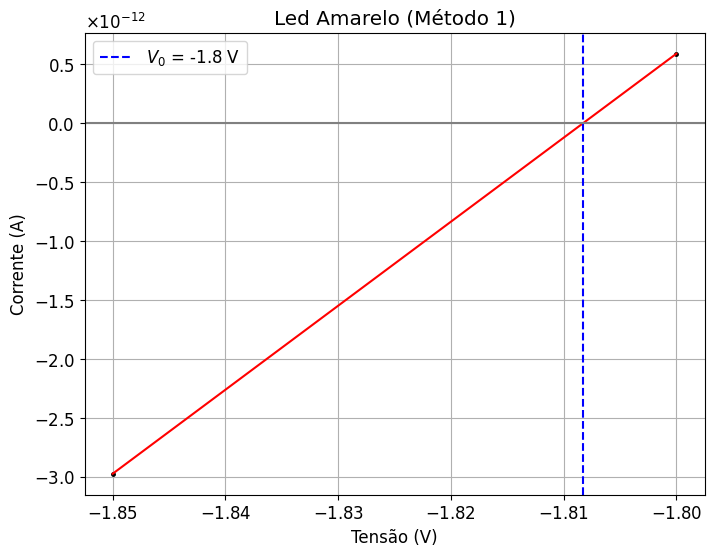

In [14]:
graphWidth = 800
graphHeight = 600

f = plt.figure(figsize=(graphWidth/100.0, graphHeight/100.0), dpi=100)
grafico = f.add_subplot(111)
# plot dos pontos:
grafico3 = grafico.plot(metodo1_x, metodo1_y, marker = '.', markersize=5, color = 'black', linewidth = 0)


# plot(dir_name_40, 'black')
# plot(dir_name_40, 'green')
# plot(dir_name_60, 'blue')
# plot(dir_name_100, 'red')


# plot do ajuste
grafico.plot(x_model_1, y_model_1,  color = 'red')


grafico.axvline(x = V0_1, color = 'blue', label = f'$V_0$ = {V0_1: .2} V', linestyle = '--')
grafico.axhline(y = 0, color = 'grey')



grafico.grid(True)
grafico.set_xlabel('Tensão (V)') # eixo x
grafico.set_ylabel('Corrente (A)') # eixo y
grafico.set_title('Led Amarelo (Método 1)') #título
grafico.legend(loc = 'upper left', fontsize= 12)


#    plt.savefig('Acr25graus.png')
plt.show()


G - Método 2

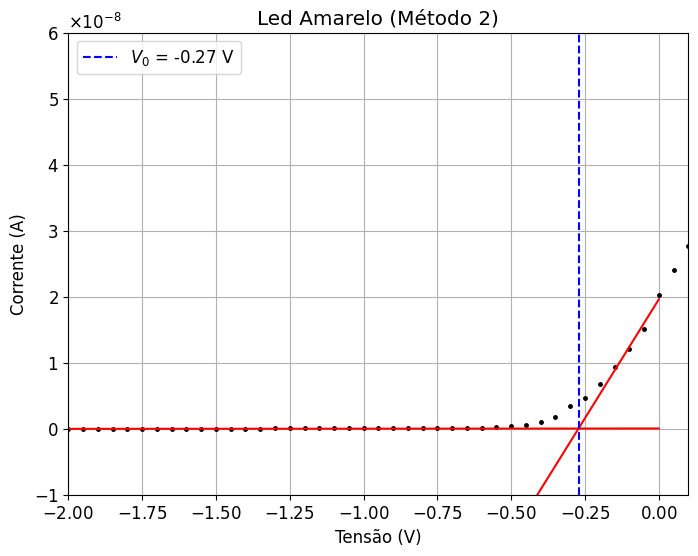

In [15]:

graphWidth = 800
graphHeight = 600

f = plt.figure(figsize=(graphWidth/100.0, graphHeight/100.0), dpi=100)
grafico = f.add_subplot(111)
# plot dos pontos:
grafico3 = grafico.plot(x_data_2, y_data_2, marker = '.', markersize=5, color = 'black', linewidth = 0)
# grafico3 = grafico.plot(x_data_p, y_data_p, marker = '.', markersize=4, color = 'black', linewidth = 0)

# plot(dir_name_40, 'black')
# plot(dir_name_40, 'green')
# plot(dir_name_60, 'blue')
# plot(dir_name_100, 'red')


# plot do ajuste
grafico.plot(x_model_n, y_model_n,  color = 'red')
grafico.plot(x_model_p, y_model_p,  color = 'red')

grafico.axvline(x = x_encontro, color = 'blue', label = f'$V_0$ = {x_encontro: .2} V', linestyle = '--')
# grafico.axvline(x = 0, color = 'grey')
# grafico.axhline(y = 0, color = 'grey')


grafico.grid(True)
grafico.set_xlabel('Tensão (V)') # eixo x
grafico.set_ylabel('Corrente (A)') # eixo y
grafico.set_title('Led Amarelo (Método 2)') #título
grafico.legend(loc = 'upper left', fontsize= 12)

plt.xlim(-2, 0.1)
plt.ylim(-10e-9, 6e-8)

#    plt.savefig('Acr25graus.png')
plt.show()


G - Método 3

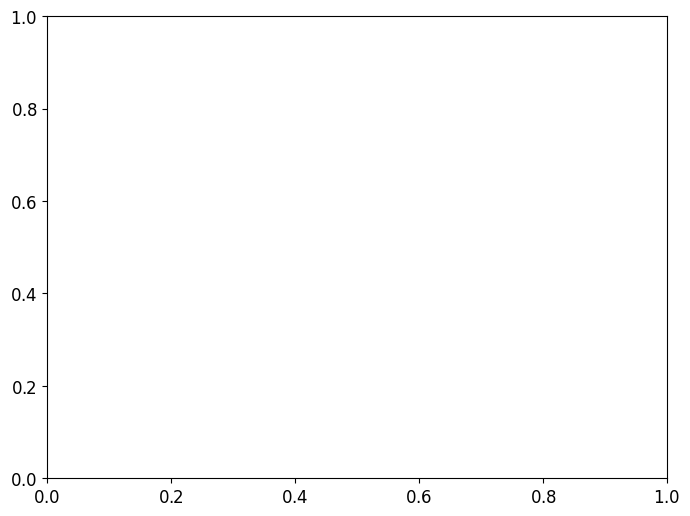

In [16]:
graphWidth = 800
graphHeight = 600

f = plt.figure(figsize=(graphWidth/100.0, graphHeight/100.0), dpi=100)
grafico = f.add_subplot(111)

G - Método 4


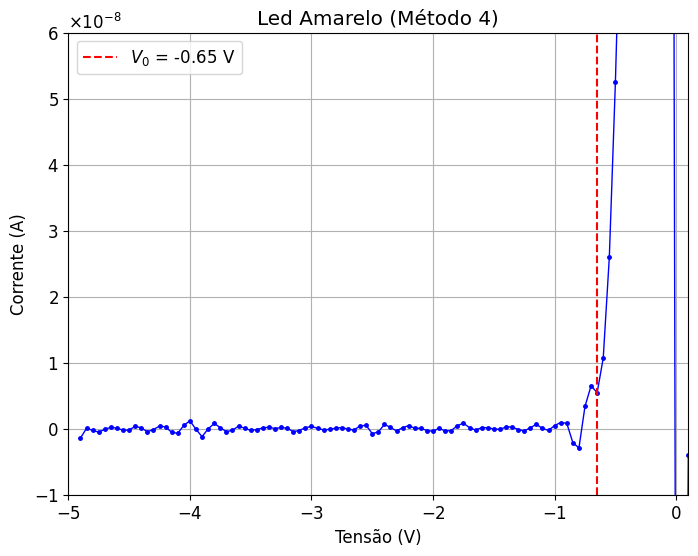

In [17]:

graphWidth = 800
graphHeight = 600

f = plt.figure(figsize=(graphWidth/100.0, graphHeight/100.0), dpi=100)
grafico = f.add_subplot(111)
# plot dos pontos:
grafico3 = grafico.plot(d2x_data, d2y_data, marker = '.', markersize=5, color = 'blue', linewidth = 1)

grafico.axvline(x = V0, color = 'red', label = f'$V_0$ = {V0: .2} V', linestyle = '--')
# grafico.axhline(y = 0, color = 'grey')

plt.xlim(-5, 0.1)
plt.ylim(-10e-9, 6e-8)
grafico.grid(True)
grafico.set_xlabel('Tensão (V)') # eixo x
grafico.set_ylabel('Corrente (A)') # eixo y
grafico.set_title('Led Amarelo (Método 4)') #título
grafico.legend(loc = 'upper left', fontsize= 12)

#    plt.savefig('Acr25graus.png')
plt.show()
